# Clustering by K-means

In [ ]:
%pip install -U -qqq scikit-learn

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import math
import os
import pickle

from _defaults import (
    CACHING_ENABLED,
    SEED,
    get_data_hash_key,
    init_notebook,
    load_ballance_datasets,
    plot_clusters,
    print_db_length_table,
)
import matplotlib.pyplot as plt

In [3]:
init_notebook()

Load (limited amount of) data.

In [4]:
data_limit = 100
_, (dataset, metadata, targets) = load_ballance_datasets(max_length=data_limit)

Load previous cached dataset from 'data/datasets-098bae95.pkl' file.


In [5]:
print_db_length_table(targets)

Dataset         Length
------------  --------
Fernverkehr        100
Güterzüge          100
Regioverkehr       100


A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN.

In [6]:
cluster_count = math.ceil(math.sqrt(len(dataset)))
print(cluster_count)

18


Prepare caching.

In [ ]:
data_hash = get_data_hash_key()

### K-means clustering (for time-series data)

In [8]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
cache_file = f"./cache/ts-kmeans-{data_hash}-{cluster_count}-{data_limit}.pkl"

if CACHING_ENABLED and os.path.exists(cache_file):
    print(f"Load previous cached ts k-means from '{cache_file}' file.")
    with open(cache_file, "rb") as f:
        km, labels = pickle.load(f)
else:
    # compute the k-means using DTW
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_jobs=-1, random_state=SEED)
    labels = km.fit_predict(dataset)
    if CACHING_ENABLED:
        with open(cache_file, "wb") as f:
            pickle.dump((km, labels), f)

/home/hein_f0/dev/slki-code/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hein_f0/dev/slki-code/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]

In [10]:
print("Cluster labels:", labels)

Cluster labels: [ 3  3 12 12 10  8 10  3 10  4  2 10  6  8  6  3  4  6  8  3  3 15 10  3
 10  8 12  4  6 12  6 15 10  3  8 10  3  3  8  3 12  6  1  4  6  6 15 10
  2  6 14 10 10  3  3  1 15  3  4  3 10 10  3  9  9 12  6 15  3  4  3  4
  6  3  3 12 12  8  6 15  4 15  8 10 12  6  6 17 15 10  3  3  3 10 12  3
  3 10 10 10  3 10  0  4 15  3  1  1  8  2  4  8  4  8  8 15 10 15  4  9
  8  6  3  8  9  7  9 15 15 15 10  4  6 15  1  6 15  1  1  4  9  2  8  8
  8  3  9  4 10 10  8  4 10  6  4  3  1  6 12  3  5  5  8 10  4  3  1 15
  3 15 10 10 13  4  3 10  8  6  3 10  8 15  3 15  8  3  6  8  8  9 15 12
  9 12  8  3 12 10  3  7 10  6  2  6  3  6  8  8  8  3 12  8  4  4  8 12
  4  3 10 12  3  8  4 15 12  8 15 10 15  3 12  8  4  0  8 12 10 10 15  6
  4  8  6  3  6  4 10  6 10 15 11  4 15 10  3 10  2 13 15  9  8 10 12  1
  8 15  8 12  8  8  3  9  9  3 12 14  4 12  4 15  3 15 12  2 12  8  3  6
 16  6 10  3  4  3 10 15  3 10 10  4]


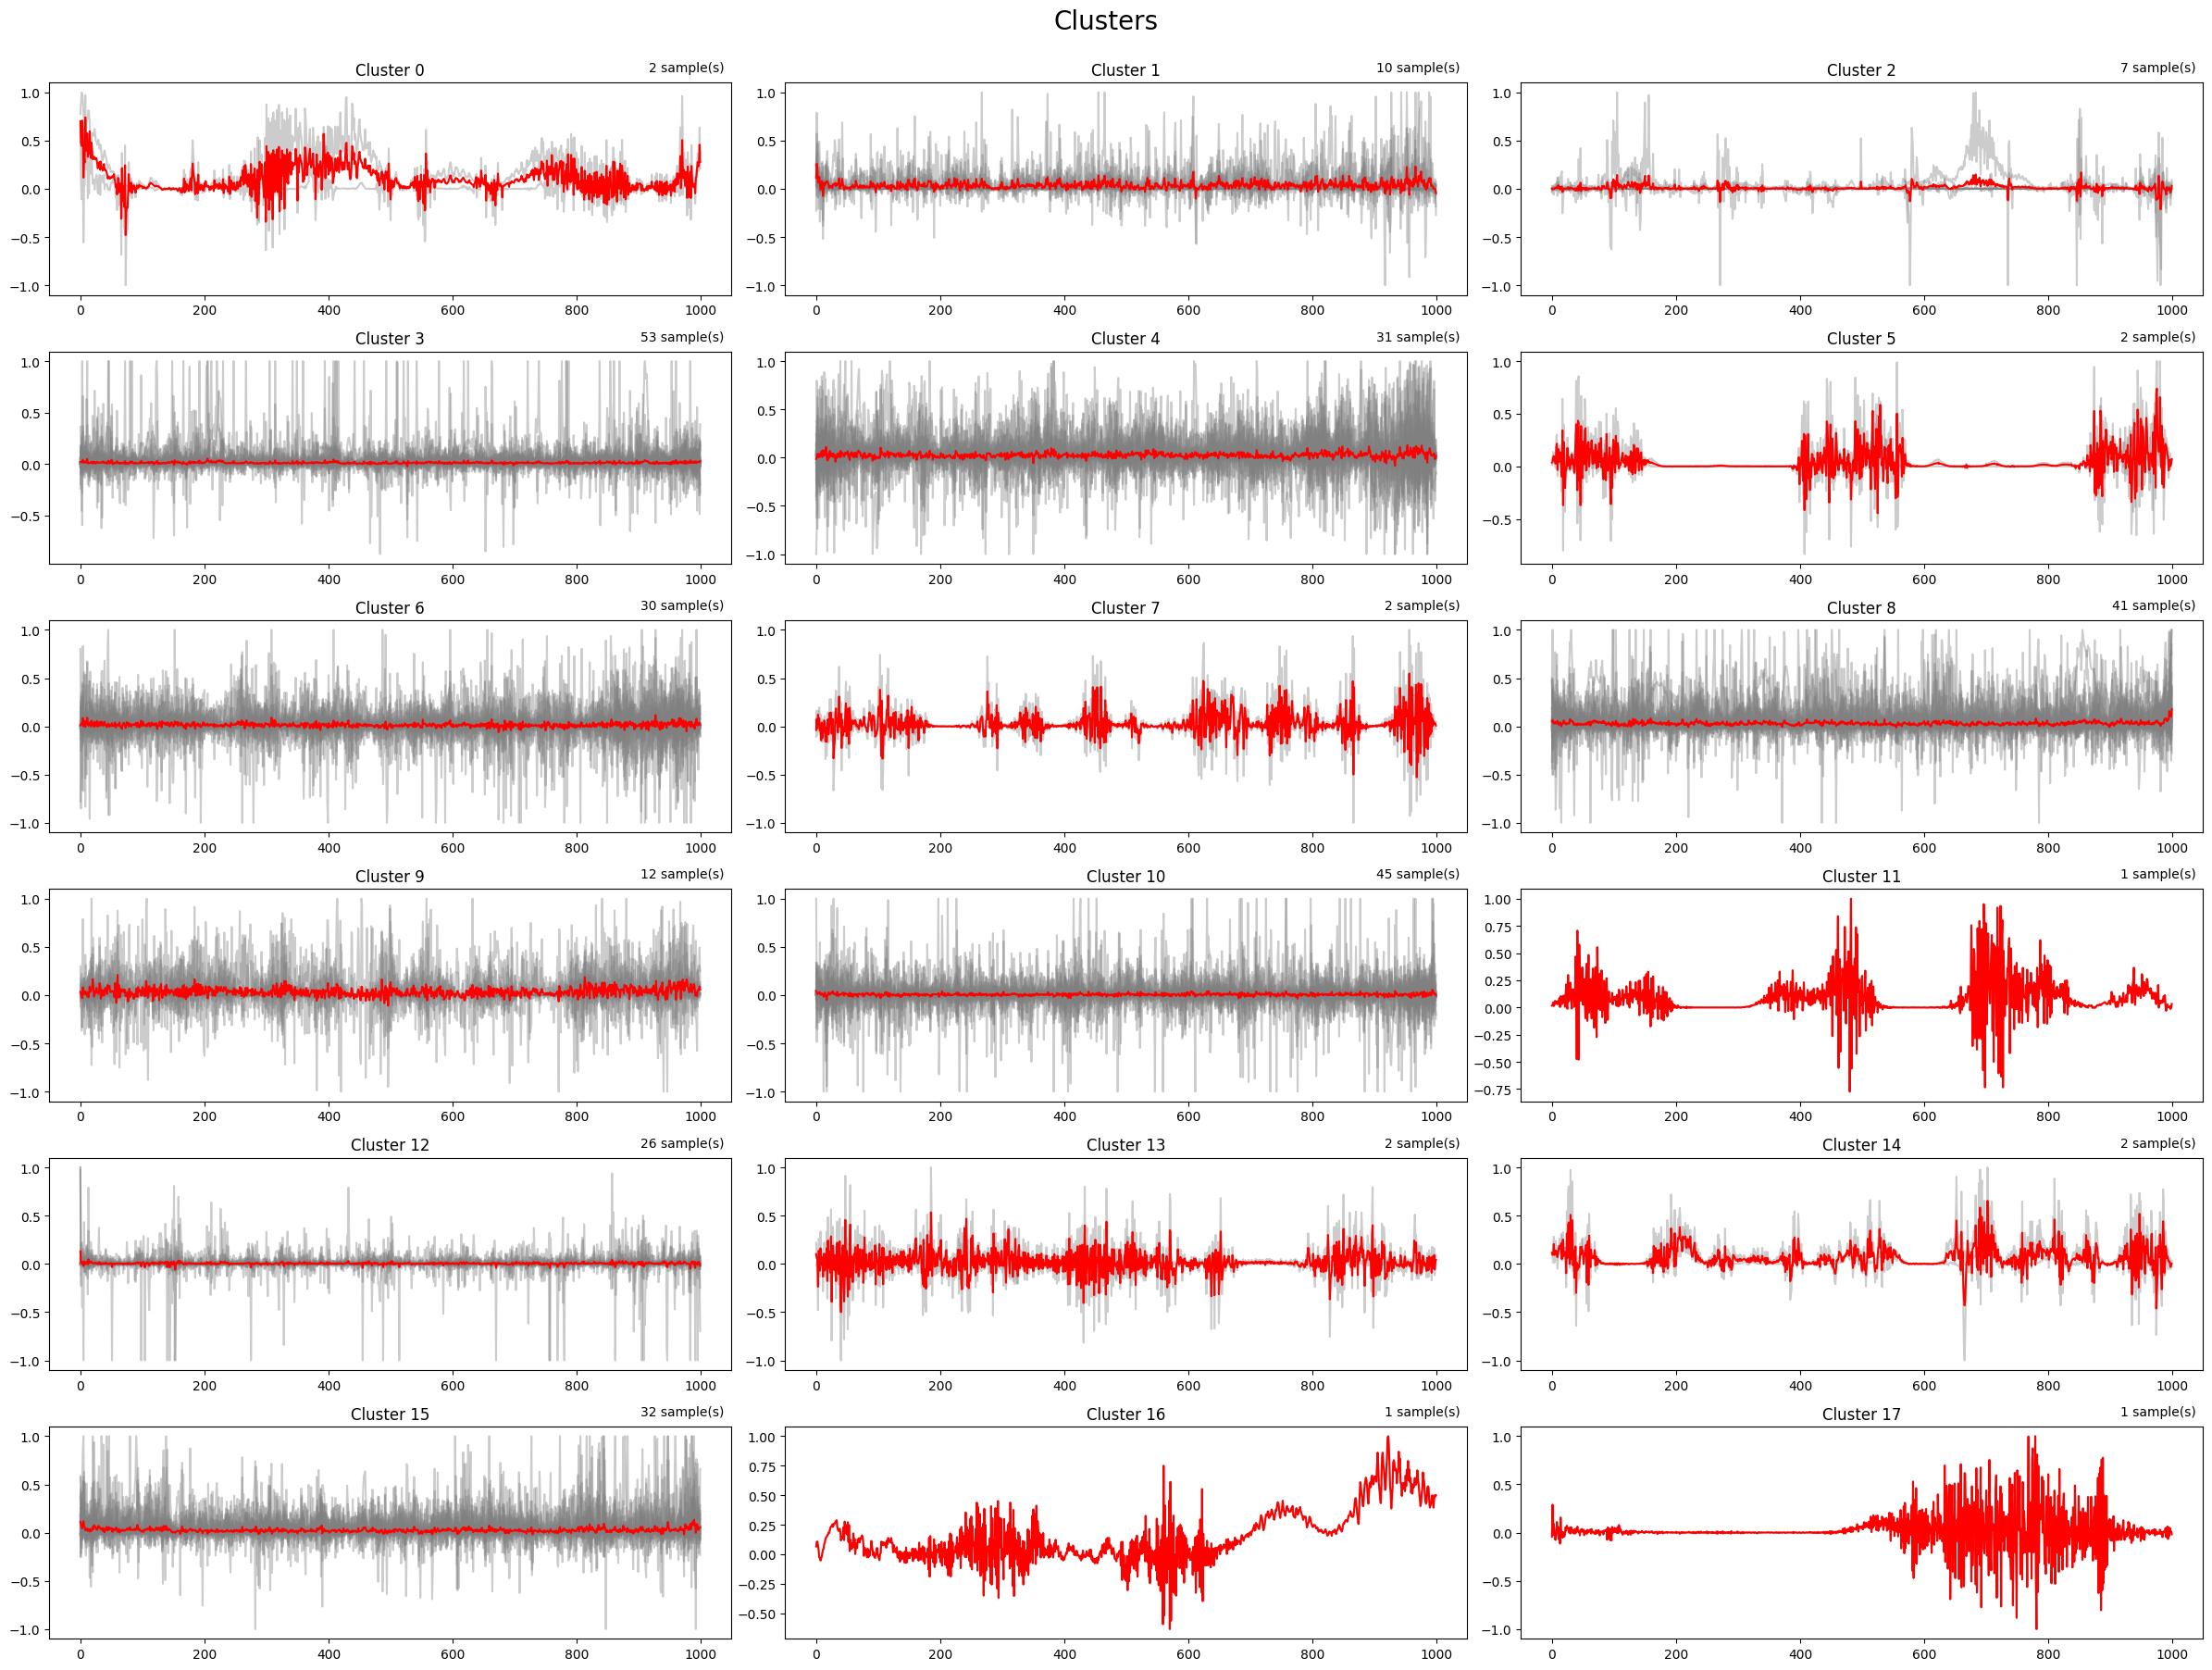

In [12]:
plot_clusters(labels, dataset)

### DTW Barycenter Averaging (DBA)

In [13]:
from tslearn.barycenters import dtw_barycenter_averaging

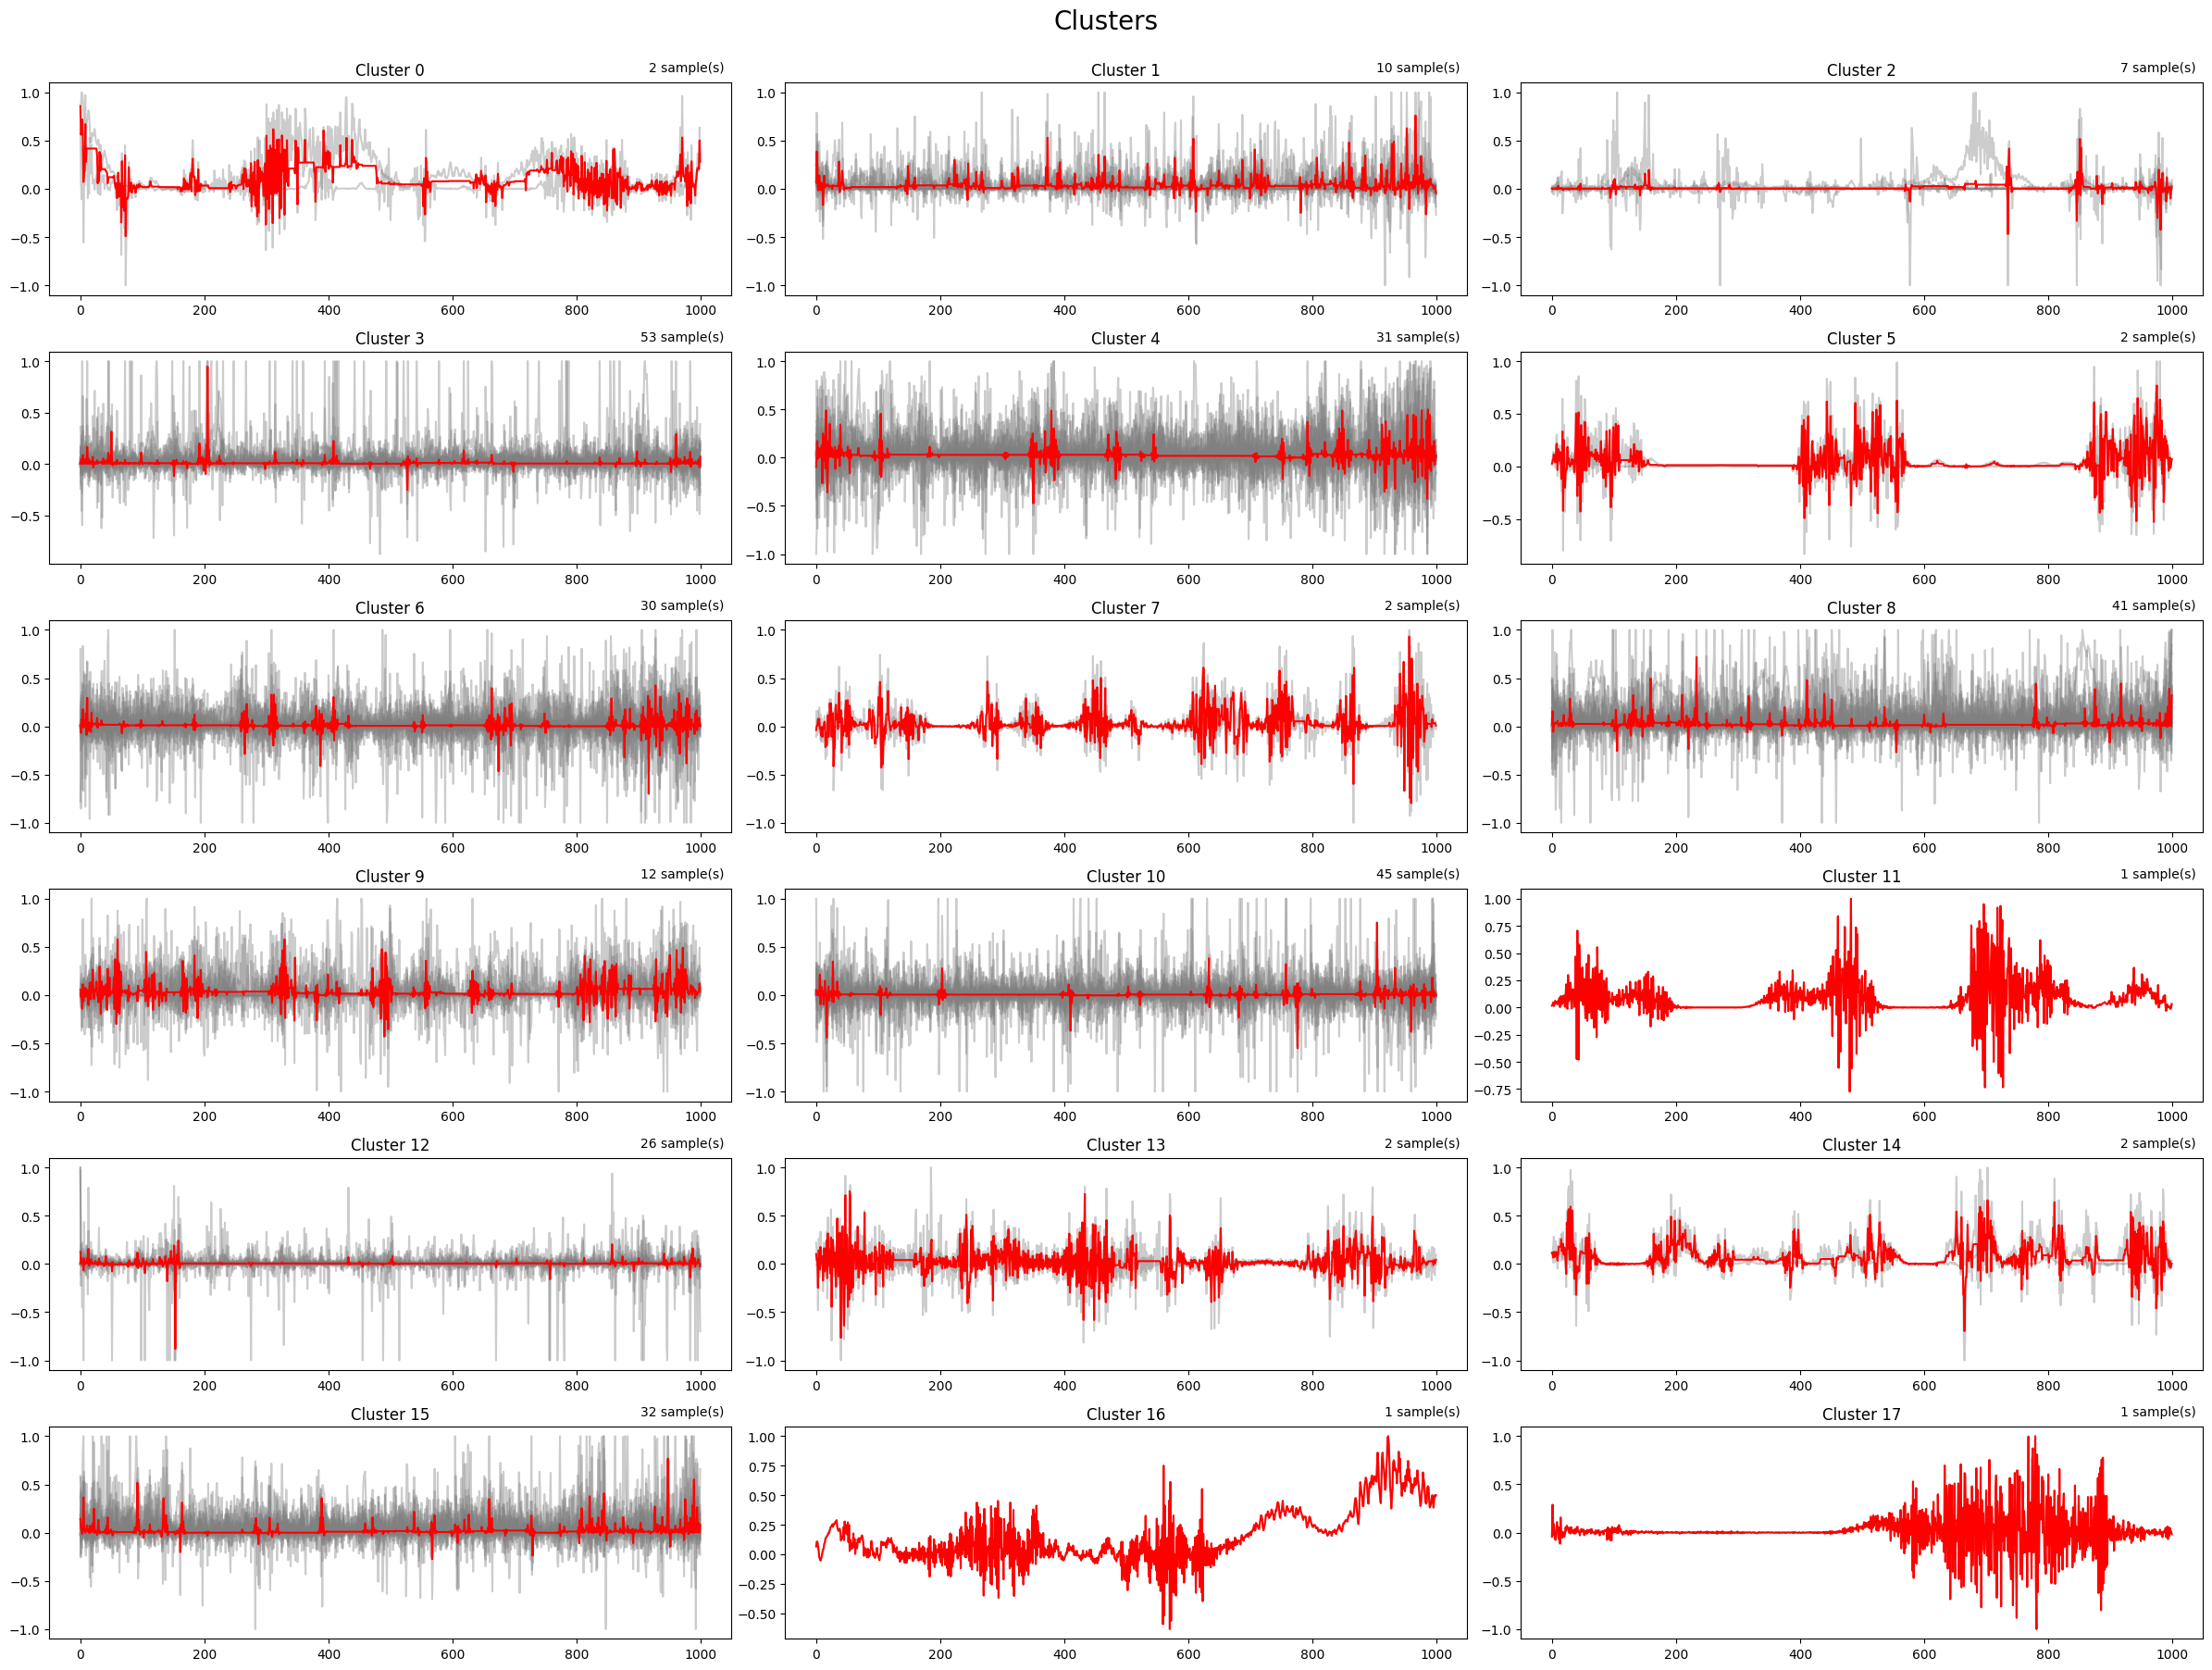

In [14]:
plot_clusters(labels, dataset, avg_fn=dtw_barycenter_averaging)

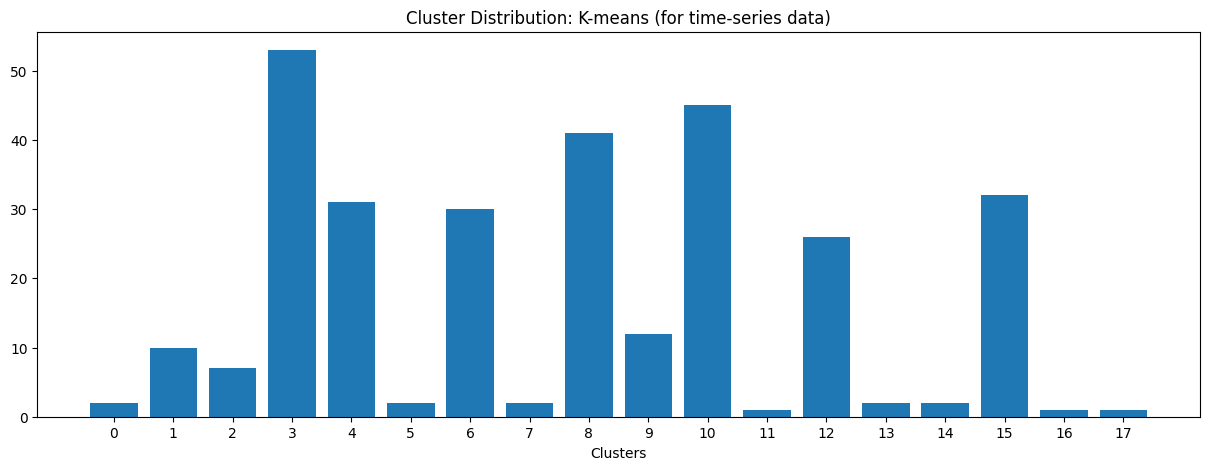

In [45]:
cluster_c = [len(labels[labels == i]) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(cluster_count)]
plt.figure(figsize=(15, 5))
plt.title("Cluster Distribution: K-means (for time-series data)")
plt.bar(cluster_n, cluster_c)
plt.gca().set_xlabel("Clusters")
plt.show()

### Principal component analysis (PCA) + K-means (for none time-series data)

In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=2, random_state=SEED)
data_pca = pca.fit_transform(dataset)

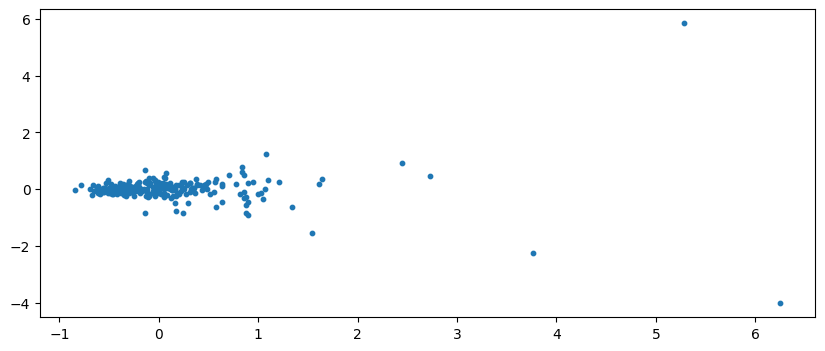

In [35]:
plt.figure(figsize=(10, 4))
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=10)
plt.show()

In [39]:
kmeans = KMeans(n_clusters=cluster_count, max_iter=5000, random_state=SEED)
kmeans_labels = kmeans.fit_predict(data_pca)

In [40]:
fancy_names_for_labels = [f"Cluster {label}" for label in kmeans_labels]

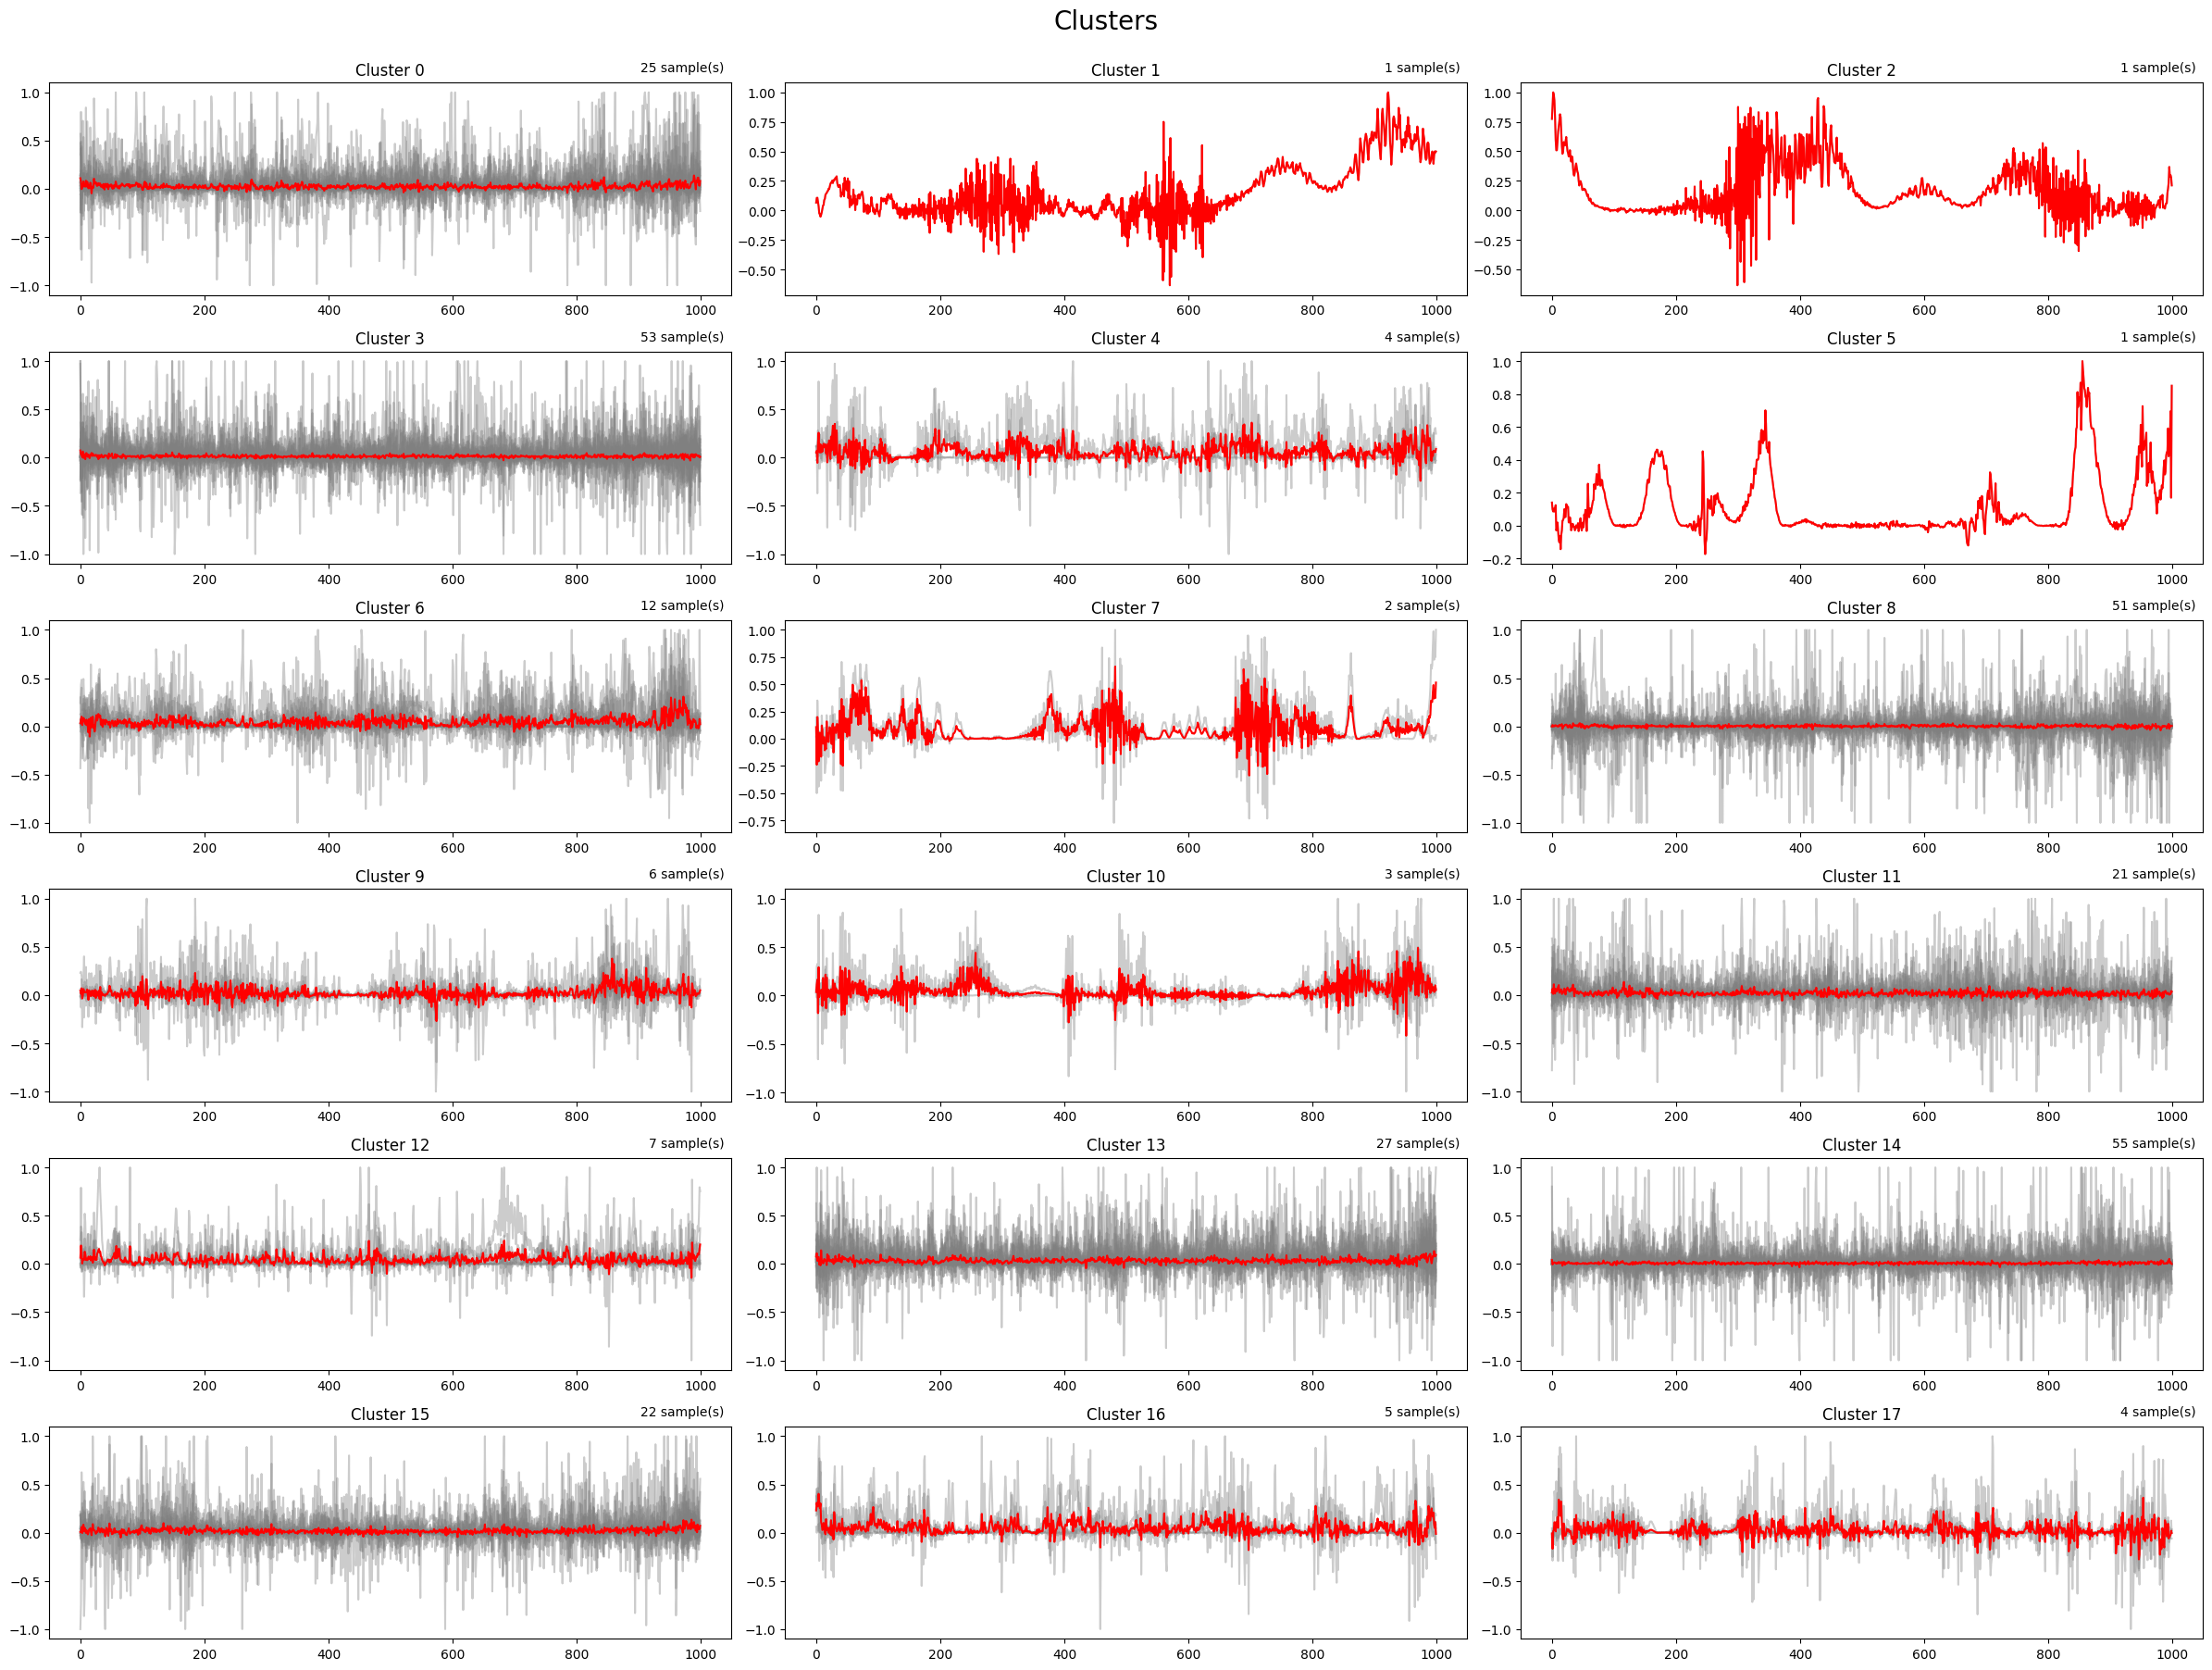

In [41]:
plot_clusters(kmeans_labels, dataset)

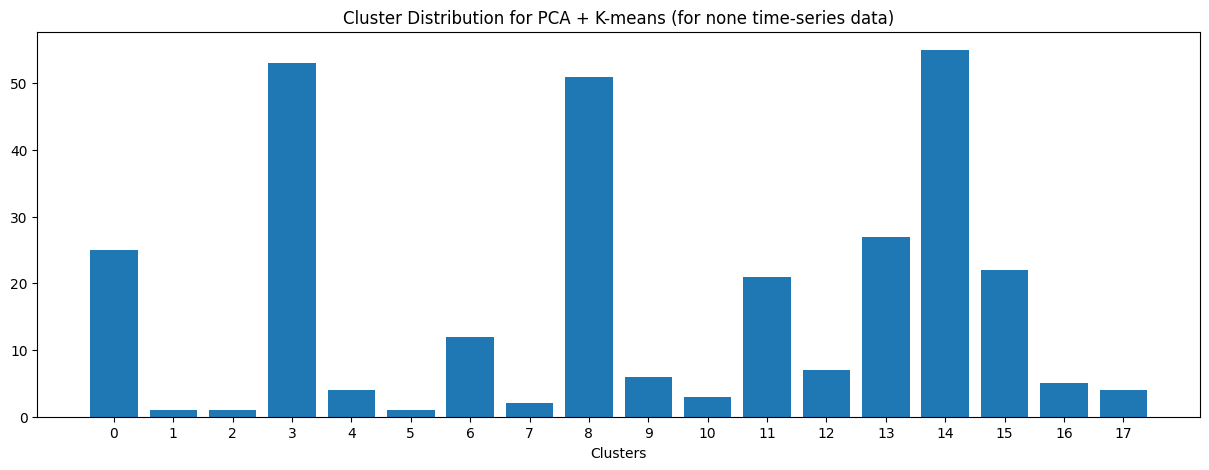

In [46]:
cluster_c = [len(kmeans_labels[kmeans_labels == i]) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(cluster_count)]
plt.figure(figsize=(15, 5))
plt.title("Cluster Distribution for PCA + K-means (for none time-series data)")
plt.bar(cluster_n, cluster_c)
plt.gca().set_xlabel("Clusters")
plt.show()